In [1]:
import os
import torch
import numpy as np
from tqdm.auto import tqdm

import mdtraj as md
import nglview as nv

import openmm as mm
import openmm.unit as unit
from openmm import app

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def compute_dihedral(positions):
    """http://stackoverflow.com/q/20305272/1128289"""
    def dihedral(p):
        if not isinstance(p, np.ndarray):
            p = p.numpy()
        b = p[:-1] - p[1:]
        b[0] *= -1
        v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
        
        # Normalize vectors
        v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
        b1 = b[1] / np.linalg.norm(b[1])
        x = np.dot(v[0], v[1])
        m = np.cross(v[0], b1)
        y = np.dot(m, v[1])
        
        return np.arctan2(y, x)
    
    angle_list = np.array([
		dihedral(p) for p in tqdm(positions, desc="Dihedrals")
	])
    
    return angle_list

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]
ALANINE_HEAVY_ATOM_IDX = [0, 4, 5, 6, 8, 10, 14, 15, 16, 18]

# State visualization

In [3]:
state = md.load("c5.pdb")
print(state.topology)
nv.show_mdtraj(state)

<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 33 bonds>


NGLWidget()

In [12]:
state_tbg = md.load("c5-bond-removed.pdb")
print(state_tbg.topology)
nv.show_mdtraj(state_tbg)

<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 21 bonds>


NGLWidget()

In [13]:
from bgmol.datasets import AImplicitUnconstrained
dataset = AImplicitUnconstrained(root=os.getcwd()+"/../../", read=True, download=False)

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



Using downloaded and verified file: /tmp/A.pdb


In [14]:
ala_traj = md.Trajectory(dataset.xyz, dataset.system.mdtraj_topology)
print(ala_traj)
nv.show_mdtraj(ala_traj)

<mdtraj.Trajectory with 1000000 frames, 22 atoms, 3 residues, without unitcells>


NGLWidget(max_frame=999999)

In [17]:
ala_traj[0].save_pdb("dataset-sample.pdb")

In [25]:
ala_sample = md.load("dataset-sample.pdb")
print(ala_sample.topology)
nv.show_mdtraj(ala_sample)

<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 21 bonds>


NGLWidget()

In [44]:
ala_sample.save("test.h5")

In [45]:
loaded = md.load("test.h5")
print(loaded.topology)

<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 21 bonds>


In [21]:
topology = dataset.system.mdtraj_topology
print(topology)

<Topology; 1 chains, 3 residues, 22 atoms, 21 bonds>


# Label generation

In [ ]:
tbg_data = torch.load("AD2_weighted.pt")
print(tbg_data.shape)

torch.Size([100000, 66])


In [3]:
tbg_data = tbg_data.reshape(-1, 22, 3)
phi = compute_dihedral(tbg_data[:, PHI_ANGLE])
psi = compute_dihedral(tbg_data[:, PSI_ANGLE])

Dihedrals:   0%|          | 0/100000 [00:00<?, ?it/s]

Dihedrals:   0%|          | 0/100000 [00:00<?, ?it/s]

In [4]:
label = np.array([0 if phi < 0 else 1 for phi in phi])
color = np.array(["red" if phi < 0 else "blue" for phi in phi])
label.shape

(100000,)

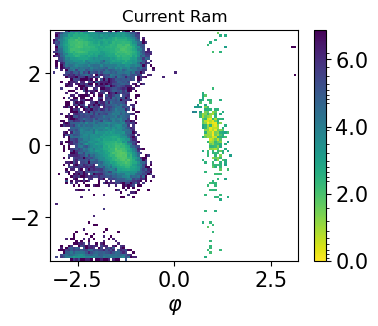

In [5]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_title("Current Ram")
ax.set_xlabel(r"$\varphi$", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=15)
cbar.ax.invert_yaxis()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


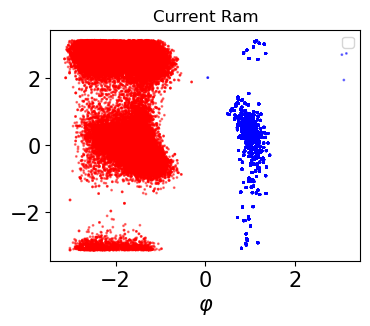

In [6]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_range = [-3.2, 3.2]
ax.scatter(phi, psi, s=1, color=color, alpha=0.5)
ax.legend()
ax.set_title("Current Ram")
ax.set_xlabel(r"$\varphi$", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

In [11]:
label_torch = torch.from_numpy(label)
torch.save(label_torch, "AD2_label.pt")

# Energy

In [28]:
tbg_data = torch.load("AD2_weighted.pt")
label_torch = torch.load("AD2_label.pt")
label1_data = tbg_data[label_torch == 1]
label0_data = tbg_data[label_torch == 0]

scaling = 10
pdb_file = "./c5-tbg.pdb"

In [17]:
def init_simulation():
    pdb = app.PDBFile(pdb_file)
    forcefield = app.ForceField("amber99sbildn.xml", "tip3p.xml")
    system = forcefield.createSystem(
		pdb.topology,
		nonbondedMethod=app.PME,
		constraints=app.HBonds,
		ewaldErrorTolerance=0.0005,
	)
    integrator = mm.LangevinIntegrator(
        300.0 * unit.kelvin,
        0.001 / unit.femtoseconds,
        1 * unit.femtoseconds
    )
    platform = mm.Platform.getPlatformByName("OpenCL")
    properties = {'DeviceIndex': '0', 'Precision': "mixed"}

    simulation = app.Simulation(
        pdb.topology,
        system,
        integrator,
        platform,
        properties
    )        
    simulation.context.setPositions(pdb.positions)   
    simulation.minimizeEnergy()
    
    return simulation

def set_simulation(simulation, frame):
    if frame is not None:
        atom_xyz = frame
        atom_list = [mm.Vec3(atom[0], atom[1], atom[2]) for atom in atom_xyz]
        current_state_openmm = unit.Quantity(value=atom_list, unit=unit.nanometer)
        simulation.context.setPositions(current_state_openmm)
    else:
        raise ValueError("Frame is None")
    
    simulation.context.setVelocities(unit.Quantity(value=np.zeros(frame.shape), unit=unit.nanometer/unit.picosecond))
    
    return simulation

def potential_energy(trajectory):
	simulation = init_simulation()
	energy_list = []

	for frame in tqdm(
		trajectory,
		desc="Calculating potential energy",
	):
		simulation = set_simulation(simulation, frame)
		energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
		energy_list.append(energy._value)

	return np.array(energy_list)

In [23]:
data1_energy = potential_energy(label1_data.reshape(-1, 22, 3) / scaling)
print(data1_energy.shape)

Calculating potential energy:   0%|          | 0/46242 [00:00<?, ?it/s]

(46242,)


In [29]:
data0_energy = potential_energy(label0_data.reshape(-1, 22, 3) / scaling )
print(data0_energy.shape)

Calculating potential energy:   0%|          | 0/53758 [00:00<?, ?it/s]

(53758,)


Text(0.5, 1.0, 'Energy distribution')

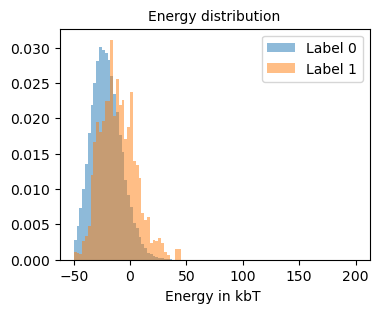

In [31]:
plt.figure(figsize=(4,3))

plt.hist(data0_energy, bins=100, range=(-50, 200), alpha=0.5, density=True, label="Label 0")
plt.hist(data1_energy, bins=100, range=(-50, 200), alpha=0.5, density=True, label="Label 1")
plt.legend(fontsize=10)
plt.xlabel("Energy in kbT ", fontsize=10)  
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Energy distribution", fontsize=10)